# TorchCrepeによる高精度ボーカル採譜
`basic-pitch` よりも単音のボーカルメロディ認識に強い `torchcrepe` を使用して、音声からMIDIへの変換を行います。

In [1]:
# 入力ファイル名
original_audio_file = "kyu_skmt.mp4"

In [ ]:
# ファイルパスの定義
import os
from pathlib import Path
audio_name = original_audio_file.split(".")[0]
original_audio_path = original_audio = Path(os.path.join(os.path.dirname(os.getcwd()), 'data', 'original', original_audio_file))
vocal_audio_path = Path(os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed', f'htdemucs/{audio_name}/vocals.mp3'))
tuned_vocal_path = Path(os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed', f'htdemucs/{audio_name}/vocals_tuned.mp3'))
for file in [original_audio_path, vocal_audio_path]:
    if not file.exists():
        raise FileNotFoundError(f"{file} not Found")
output_midi_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed', f'htdemucs/{audio_name}/vocals_transcribed.mid')

In [3]:
import librosa
# 原曲からピッチ推測
y, sr = librosa.load(original_audio_path)  # Load the mixed audio file with a sample rate of 16kHz
tempo = librosa.feature.tempo(y=y, sr=sr)
tuning_offset = librosa.estimate_tuning(y=y, sr=sr)
print(f"The offset from A=440Hz is: {tuning_offset:.4f} semitones")
estimated_freq = 440 * (2 ** (tuning_offset / 12))
print(f"Estimated Reference Frequency: {estimated_freq:.2f} Hz")

# ピッチ補正の実行
y, sr = librosa.load(vocal_audio_path)  # Load the mixed audio file with a sample rate of 16kHz
if abs(tuning_offset) < 0.01:
    print("The track is already well-tuned to A=440Hz.")
    print("Skipping pitch shift.")
    y_shifted = y
else:
    print(f"The track is detuned. Adjustment needed: {-tuning_offset:.4f} semitones.")
    print("Applying pitch shift...")
    # librosa.effects.pitch_shift は高品質ですが処理が重い場合があります
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=-tuning_offset)
    
    # 補正後の確認
    new_offset = librosa.estimate_tuning(y=y_shifted, sr=sr)
    print(f"New tuning offset: {new_offset:.4f} semitones")
    estimated_freq = 440 * (2 ** (new_offset / 12))
    print(f"Estimated Reference Frequency: {estimated_freq:.2f} Hz")

import soundfile as sf
output_path = tuned_vocal_path
sf.write(output_path, y_shifted, sr)
print(f"Saved tuned audio to: {output_path}")

/var/folders/rv/hmpprb6j6y38jxsvwy_sqp7c0000gn/T/ipykernel_6247/33833254.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(original_audio_path)  # Load the mixed audio file with a sample rate of 16kHz
/Users/kpome/github/solfege-gen/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


The offset from A=440Hz is: -0.0800 semitones
Estimated Reference Frequency: 437.97 Hz
The track is detuned. Adjustment needed: 0.0800 semitones.
Applying pitch shift...
New tuning offset: 0.1900 semitones
Estimated Reference Frequency: 444.86 Hz
Saved tuned audio to: /Users/kpome/github/solfege-gen/data/processed/htdemucs/kyu_skmt/vocals_tuned.mp3


### TorchCREPE

In [4]:
import torch
import torchcrepe
import librosa
import numpy as np
import pretty_midi
import os
from pathlib import Path
import matplotlib.pyplot as plt

# ファイルパスの設定
project_root = Path(os.getcwd()).parent
input_file = vocal_audio_path

# 以前の工程で作ったチューニング補正済みのファイルがあればそれを使う

if tuned_vocal_path.exists():
    print(f"Using tuned file: {tuned_vocal_path}")
    input_file = tuned_vocal_path
else:
    print(f"Using original file: {input_file}")
device = 'mps'

/Users/kpome/github/solfege-gen/.venv/lib/python3.11/site-packages/resampy/filters.py:50: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Using tuned file: /Users/kpome/github/solfege-gen/data/processed/htdemucs/kyu_skmt/vocals_tuned.mp3


In [5]:
# 音声の読み込みと前処理
# CREPEは16kHzのサンプリングレートが必要です
audio, sr = librosa.load(str(input_file), sr=16000)

# テンソルへの変換とバッチ次元 (1, length) の追加
audio_tensor = torch.tensor(np.copy(audio)).unsqueeze(0).to(device)

print(f"Loaded audio shape: {audio_tensor.shape}")

Loaded audio shape: torch.Size([1, 2197212])


In [6]:
# ピッチ推定 (Inference)
HOP_LENGTH = 160  # 10ms (16000Hz / 100)

print("Predicting pitch...")
try:
    f0, confidence = torchcrepe.predict(
        audio_tensor,
        sample_rate=16000,
        hop_length=HOP_LENGTH,
        fmin=50,
        fmax=2000,
        model='full',
        decoder=torchcrepe.decode.viterbi,
        return_periodicity=True,
        batch_size=256, # 2048 -> 128 に変更 (メモリ負荷軽減)
        device=device
    )
    print("Pitch prediction complete.")

except RuntimeError as e:
    print(f"Error during prediction: {e}")
    print("Trying with lighter settings (model='tiny', batch_size=64)...")
    # フォールバック: 軽量モデル設定
    f0, confidence = torchcrepe.predict(
        audio_tensor,
        sample_rate=16000,
        hop_length=HOP_LENGTH,
        fmin=50,
        fmax=2000,
        model='tiny',
        decoder=torchcrepe.decode.weighted_argmax, # Viterbiより軽い
        return_periodicity=True,
        batch_size=64,
        device=device
    )
    print("Prediction complete with lighter settings.")
print("estimation completed")
f0 = f0.squeeze().detach().cpu().numpy()
confidence = confidence.squeeze().detach().cpu().numpy()

Predicting pitch...
Pitch prediction complete.
estimation completed


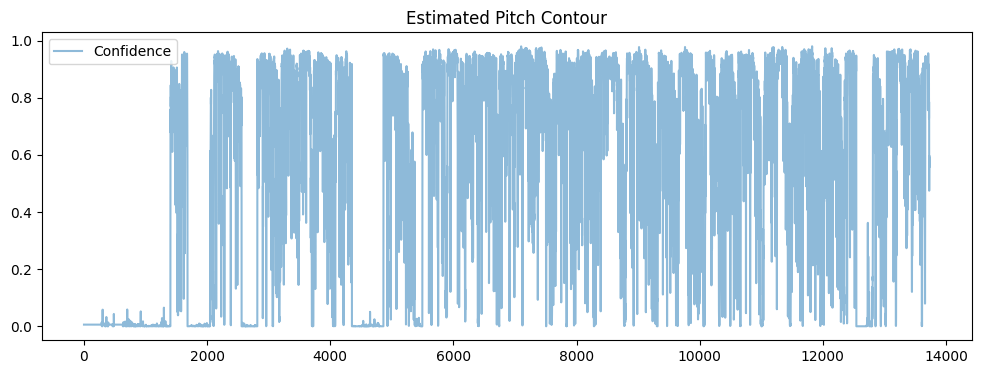

In [7]:
# プロットして確認
plt.figure(figsize=(12, 4))
plt.plot(confidence, label='Confidence', alpha=0.5)
plt.legend()
plt.title("Estimated Pitch Contour")
plt.show()

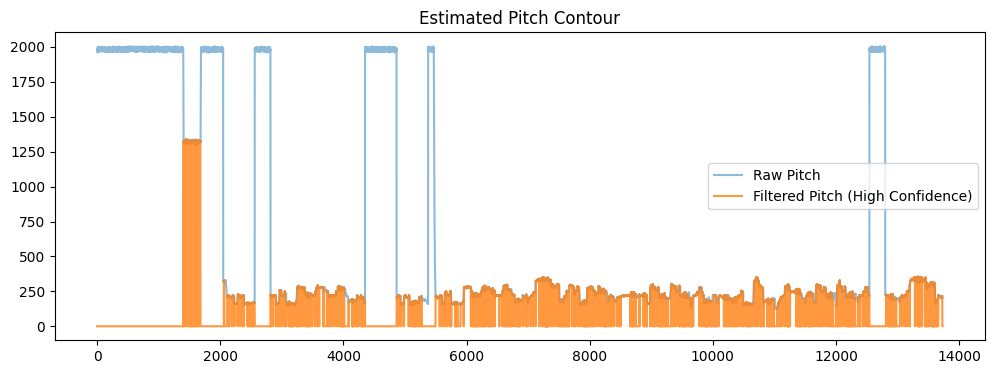

In [8]:
# 信頼度が低い部分（無音やノイズ）をフィルタリング
CONFIDENCE_THRESHOLD = 0.7
f0_filtered = np.copy(f0)
f0_filtered[confidence < CONFIDENCE_THRESHOLD] = 0

# プロットして確認
plt.figure(figsize=(12, 4))
plt.plot(f0, label='Raw Pitch', alpha=0.5)
plt.plot(f0_filtered, label='Filtered Pitch (High Confidence)', alpha=0.8)
plt.legend()
plt.title("Estimated Pitch Contour")
plt.show()

In [9]:
midi_obj = pretty_midi.PrettyMIDI()
inst = pretty_midi.Instrument(program=0)  # 0: Grand Piano

current_note = None
onset_time = 0

# 周波数をMIDIノート番号に変換 (四捨五入して半音単位に)
midi_notes_seq = librosa.hz_to_midi(f0_filtered)
midi_notes_seq[f0_filtered == 0] = 0 # 無音を0に戻す
midi_notes_seq = np.round(midi_notes_seq)

/Users/kpome/github/solfege-gen/.venv/lib/python3.11/site-packages/librosa/core/convert.py:1094: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


In [10]:
# ピッチデータをMIDIノートイベントに変換 (簡易的な量子化)
# f0の時系列データを「ノートの開始・終了・高さ」形式にします

def f0_to_midi(f0_sequence, hop_length_seconds, min_duration=0.1):
    midi_obj = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=0)  # 0: Grand Piano
    
    current_note = None
    onset_time = 0
    
    # 周波数をMIDIノート番号(0~127)に変換 (四捨五入して半音単位に)
    midi_notes_seq = librosa.hz_to_midi(f0_sequence)
    midi_notes_seq[f0_sequence == 0] = 0 # 無音を0に戻す
    midi_notes_seq = np.round(midi_notes_seq)
    
    for i, note_num in enumerate(midi_notes_seq):
        time = i * hop_length_seconds
        
        # 音がない、または音が変わった場合
        if current_note is not None:
            if note_num != current_note.pitch or i == len(midi_notes_seq) - 1:
                # ノート終了処理
                duration = time - onset_time
                if duration >= min_duration:
                    current_note.end = time
                    inst.notes.append(current_note)
                current_note = None
        
        # 新しい音が始まった場合
        if note_num > 0 and current_note is None:
            onset_time = time
            current_note = pretty_midi.Note(
                velocity=100,
                pitch=int(note_num),
                start=onset_time,
                end=onset_time # 仮
            )

    midi_obj.instruments.append(inst)
    return midi_obj

# MIDI変換実行
midi_result = f0_to_midi(f0, hop_length_seconds=HOP_LENGTH/16000)

# 保存
output_midi_path = project_root / 'data' / 'processed' / 'htdemucs' / 'sample_kaze' / 'vocals_crepe.mid'
midi_result.write(str(output_midi_path))
print(f"Saved MIDI to: {output_midi_path}")

Saved MIDI to: /Users/kpome/github/solfege-gen/data/processed/htdemucs/sample_kaze/vocals_crepe.mid


In [11]:
import music21 as m21
midi_stream = m21.converter.parse(str(output_midi_path))
midi_stream.show('midi')

### MIDI_seq to MIDIを改善

#### Onsetとの組み合わせによる音符開始位置の分析

In [12]:
y, sr = librosa.load(vocal_audio_path, sr=16000)

In [13]:
# onset: 音符の開始位置
onset_frame = librosa.onset.onset_detect(y=y, sr=sr, hop_length=HOP_LENGTH) # (num_onsets,)
hop_length_seconds = HOP_LENGTH/16000

In [14]:
print(sr)

16000


In [30]:
midi_obj = pretty_midi.PrettyMIDI()
inst = pretty_midi.Instrument(program=0)  # 0: Grand Piano

null_seq = np.zeros((onset_frame.max()))
for i, onset in enumerate(onset_frame):
    time = onset * hop_length_seconds
    if len(inst.notes) == 0:
        note = pretty_midi.Note(
            velocity=80,
            pitch=80,
            start=0,
            end=time
        )
    else:
        prev_end_time = onset_frame[i-1] * hop_length_seconds
        note = pretty_midi.Note(
            velocity=80, 
            pitch=80, 
            start=prev_end_time,
            end=time
            )
    inst.notes.append(note)

midi_obj.instruments.append(inst)
output_midi_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'exp', f'{audio_name}_onset.mid')
midi_obj.write(output_midi_path)

In [31]:
import IPython.display as ipd
audio = midi_obj.synthesize(fs=int(sr))
ipd.Audio(audio, rate=sr)

In [34]:
from pydub import AudioSegment
import numpy as np

# float配列をint16に正しく変換
audio_int16 = np.int16(audio / np.max(np.abs(audio)) * 32767)
onset_audio = AudioSegment(
    audio_int16.tobytes(),
    frame_rate=sr,
    sample_width=2,
    channels=1
)
vocal_audio = AudioSegment.from_file(vocal_audio_path)

In [35]:
mixed = onset_audio.overlay(vocal_audio)
onset_with_vocal = os.path.join(os.path.dirname(os.getcwd()), 'data', 'exp', f'{audio_name}_onset.mp3')
mixed.export(onset_with_vocal, format="mp3")

<_io.BufferedRandom name='/Users/kpome/github/solfege-gen/data/exp/kyu_skmt_onset.mp3'>